In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import datasets,transforms

from torch.utils.data import DataLoader,SubsetRandomSampler,sampler
import numpy as np

import matplotlib.colors as mcolors

In [2]:
def get_data_loader_mnist(batch_size,num_workers=0,validation_fraction=0
                          ,train_transforms=None,test_transforms=None):
  if train_transforms is None:
    train_transforms = transforms.ToTensor()
  
  if test_transforms is None:
    test_transforms = transforms.ToTensor()

  
  train_dataset = datasets.MNIST(root='data',train=True,transform=train_transforms,download=True)

  valid_dataset = datasets.MNIST(root='data',train=True,transform=test_transforms)

  test_dataset = datasets.MNIST(root='data',train=False,transform=test_transforms) 


  if validation_fraction is not None:
    num = int(validation_fraction * 60000)

    train_indices = np.arange(0,60000-num)
    val_indices = np.arange(60000-num,60000)

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    valid_loader = DataLoader(dataset = valid_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              sampler=valid_sampler)
    
    train_loader = DataLoader(dataset = train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              drop_last=True,
                              sampler=train_sampler)
    
  else:
    train_loader = DataLoader(dataset = train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
    
  
  test_loader = DataLoader(dataset = test_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                            shuffle=False)
  
  if validation_fraction is None:
    return train_loader,test_loader

  else:
    return train_loader,valid_loader,test_loader
    

In [3]:
train_loader, valid_loader, test_loader = get_data_loader_mnist(
    batch_size=256, 
    num_workers=2, 
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
#Checking the dataset
print("Training set:")
for images,labels in train_loader:
  print('Image batch dimensions:', images.size())
  print('Image label dimensions:', labels.size())
  print(labels[:10])
  break


# Checking the dataset
print('Testing Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break


Training set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([4, 4, 7, 8, 2, 1, 1, 1, 6, 8])
Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


In [ ]:
class Reshape(nn.Module):
  def __init__(self,*args):
    super().__init__()
    self.shape=args
  
  def forward(self,x):
    #print(x.shape)
    return x.view(self.shape)


class Trim(nn.Module):
  def __init__(self,*args):
    super().__init__()
  
  def forward(self,x):
    return x[:,:,:28,:28] # removing 1 pixel going from 29 to 28


class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,32,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.Flatten(),
        nn.Linear(3136,2) #only 2 hidden features as per the diagram 
        #because 3136 = 64x7x7
    )

    self.decoder = nn.Sequential(
        nn.Linear(2,3136),
        Reshape(-1,64,7,7),
        nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,32,stride=(2,2),kernel_size=(3,3),padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32,1,stride=(1,1),kernel_size=(3,3),padding=0),
        Trim(), # 1 x 29 x 29 -> 1x28x28 
        nn.Sigmoid() 
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x




In [ ]:
model = AutoEncoder()

In [ ]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyR

In [5]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [15]:
def train_autoencoder(num_epochs, model, optimizer, train_loader,loss_fn=None,
              logging_interval=100,skip_epoch_stats=False,
              reconstruction_term_weight=1,
              save_model=None):
  
  log_dict = {'train_loss_per_batch': []}

  if loss_fn is None:
    loss_fn = nn.functional.mse_loss
  
  for epoch in range(num_epochs):

    model.train()

    for batch_idx, (features,_) in enumerate(train_loader):

      #print(features.shape)

      #forward and back prop
      logits = model(features)

      # print(logits.shape)

      loss = loss_fn(logits,features)
     
      optimizer.zero_grad()

      loss.backward()

      #update model parameters
      optimizer.step()

      #Logging
      log_dict['train_loss_per_batch'].append(loss.item())

      if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))
    if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())
    
  if save_model is not None:
    torch.save(model.state_dict(), save_model)
  
  return log_dict



In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

In [ ]:
log_dict = train_autoencoder(num_epochs=10, model=model, 
                        optimizer=optimizer, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/010 | Batch 0000/0234 | Loss: 0.2175
Epoch: 001/010 | Batch 0050/0234 | Loss: 0.0692
Epoch: 001/010 | Batch 0100/0234 | Loss: 0.0664
Epoch: 001/010 | Batch 0150/0234 | Loss: 0.0646
Epoch: 001/010 | Batch 0200/0234 | Loss: 0.0598
Epoch: 002/010 | Batch 0000/0234 | Loss: 0.0560
Epoch: 002/010 | Batch 0050/0234 | Loss: 0.0565
Epoch: 002/010 | Batch 0100/0234 | Loss: 0.0553
Epoch: 002/010 | Batch 0150/0234 | Loss: 0.0521
Epoch: 002/010 | Batch 0200/0234 | Loss: 0.0527
Epoch: 003/010 | Batch 0000/0234 | Loss: 0.0514
Epoch: 003/010 | Batch 0050/0234 | Loss: 0.0504
Epoch: 003/010 | Batch 0100/0234 | Loss: 0.0505
Epoch: 003/010 | Batch 0150/0234 | Loss: 0.0496
Epoch: 003/010 | Batch 0200/0234 | Loss: 0.0498
Epoch: 004/010 | Batch 0000/0234 | Loss: 0.0530
Epoch: 004/010 | Batch 0050/0234 | Loss: 0.0481
Epoch: 004/010 | Batch 0100/0234 | Loss: 0.0514
Epoch: 004/010 | Batch 0150/0234 | Loss: 0.0460
Epoch: 004/010 | Batch 0200/0234 | Loss: 0.0449
Epoch: 005/010 | Batch 0000/0234 | Loss:

In [ ]:
torch.save(model, 'Encoder.pth')

###Training Loss

In [7]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

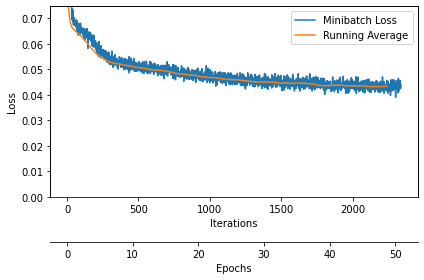

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], 50)

###Generate Images

In [8]:
def plot_generated_images(data_loader, model, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            decoded_image = model(features)[:n_images]
            
        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_image]):
            curr_img = img[i]      
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

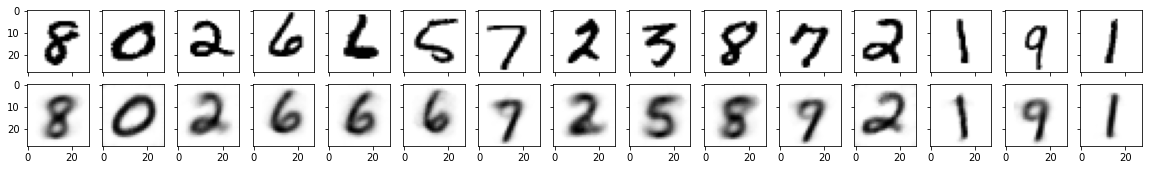

In [ ]:
plot_generated_images(data_loader=train_loader, model=model) 

###Latent Space

In [9]:
def plot_latent_space_with_labels(num_classes, data_loader):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
            
            embedding = model.encoder(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask])

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

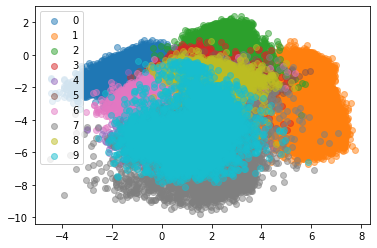

In [ ]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader)

plt.legend()
plt.show()

#The latent space is overlapped and is not continuous. 
#Not centred at a particular point.
#Hence the model can get confused btw two classes due to overlapping latent space.

###Generating Image for a given point

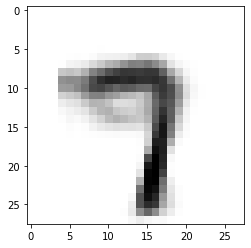

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.0, -8.0]))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image, cmap='binary')
plt.show()

###Making the encoder output bigger dimensions

In [31]:
class Reshape(nn.Module):
  def __init__(self,*args):
    super().__init__()
    self.shape=args
  
  def forward(self,x):
    #print(x.shape)
    return x.view(self.shape)


class Trim(nn.Module):
  def __init__(self,*args):
    super().__init__()
  
  def forward(self,x):
    return x[:,:,:28,:28] # removing 1 pixel going from 29 to 28


class AutoEncoder_v2(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,32,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.Flatten(),
        nn.Linear(3136,4) #only 2 hidden features as per the diagram 
        #because 3136 = 64x7x7
    )

    self.decoder = nn.Sequential(
        nn.Linear(4,3136),
        Reshape(-1,64,7,7),
        nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,32,stride=(2,2),kernel_size=(3,3),padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32,1,stride=(1,1),kernel_size=(3,3),padding=0),
        Trim(), # 1 x 29 x 29 -> 1x28x28 
        nn.Sigmoid() 
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x




In [32]:
model = AutoEncoder_v2()

In [33]:
model

AutoEncoder_v2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): Lea

In [34]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

In [35]:
log_dict = train_autoencoder(num_epochs=10, model=model, 
                        optimizer=optimizer, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/010 | Batch 0000/0234 | Loss: 0.2578
Epoch: 001/010 | Batch 0050/0234 | Loss: 0.0764
Epoch: 001/010 | Batch 0100/0234 | Loss: 0.0680
Epoch: 001/010 | Batch 0150/0234 | Loss: 0.0656
Epoch: 001/010 | Batch 0200/0234 | Loss: 0.0526
Epoch: 002/010 | Batch 0000/0234 | Loss: 0.0464
Epoch: 002/010 | Batch 0050/0234 | Loss: 0.0456
Epoch: 002/010 | Batch 0100/0234 | Loss: 0.0460
Epoch: 002/010 | Batch 0150/0234 | Loss: 0.0426
Epoch: 002/010 | Batch 0200/0234 | Loss: 0.0395
Epoch: 003/010 | Batch 0000/0234 | Loss: 0.0372
Epoch: 003/010 | Batch 0050/0234 | Loss: 0.0373
Epoch: 003/010 | Batch 0100/0234 | Loss: 0.0388
Epoch: 003/010 | Batch 0150/0234 | Loss: 0.0384
Epoch: 003/010 | Batch 0200/0234 | Loss: 0.0363
Epoch: 004/010 | Batch 0000/0234 | Loss: 0.0339
Epoch: 004/010 | Batch 0050/0234 | Loss: 0.0374
Epoch: 004/010 | Batch 0100/0234 | Loss: 0.0348
Epoch: 004/010 | Batch 0150/0234 | Loss: 0.0336
Epoch: 004/010 | Batch 0200/0234 | Loss: 0.0331
Epoch: 005/010 | Batch 0000/0234 | Loss:

In [41]:
log_dict1 = train_autoencoder(num_epochs=5, model=model, 
                        optimizer=optimizer, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/005 | Batch 0000/0234 | Loss: 0.0297
Epoch: 001/005 | Batch 0050/0234 | Loss: 0.0288
Epoch: 001/005 | Batch 0100/0234 | Loss: 0.0290
Epoch: 001/005 | Batch 0150/0234 | Loss: 0.0289
Epoch: 001/005 | Batch 0200/0234 | Loss: 0.0294
Epoch: 002/005 | Batch 0000/0234 | Loss: 0.0302
Epoch: 002/005 | Batch 0050/0234 | Loss: 0.0305
Epoch: 002/005 | Batch 0100/0234 | Loss: 0.0296
Epoch: 002/005 | Batch 0150/0234 | Loss: 0.0292
Epoch: 002/005 | Batch 0200/0234 | Loss: 0.0318
Epoch: 003/005 | Batch 0000/0234 | Loss: 0.0282
Epoch: 003/005 | Batch 0050/0234 | Loss: 0.0302
Epoch: 003/005 | Batch 0100/0234 | Loss: 0.0265
Epoch: 003/005 | Batch 0150/0234 | Loss: 0.0296
Epoch: 003/005 | Batch 0200/0234 | Loss: 0.0318
Epoch: 004/005 | Batch 0000/0234 | Loss: 0.0303
Epoch: 004/005 | Batch 0050/0234 | Loss: 0.0284
Epoch: 004/005 | Batch 0100/0234 | Loss: 0.0299
Epoch: 004/005 | Batch 0150/0234 | Loss: 0.0299
Epoch: 004/005 | Batch 0200/0234 | Loss: 0.0294
Epoch: 005/005 | Batch 0000/0234 | Loss:

In [42]:
torch.save(model, 'EncoderWith4DimensionOutput.pth')

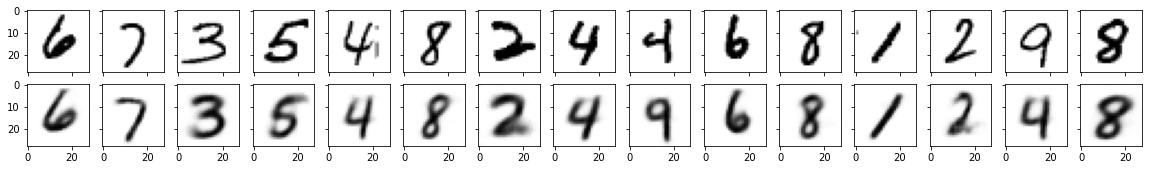

In [43]:
plot_generated_images(data_loader=train_loader, model=model) 

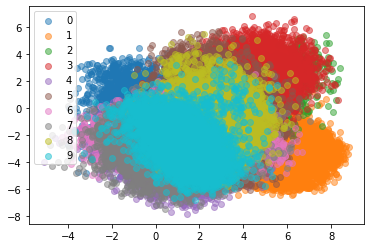

In [44]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader)

plt.legend()
plt.show()

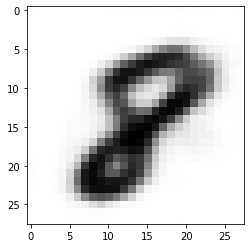

In [45]:
import random
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.0,-2.0,0.0,0.0]))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image, cmap='binary')
plt.show()